In [70]:
import pandas as pd
import numpy as np

# For Plotting various Diagrams for comparision
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

# To Show the most frequent words in Normal and Phishing Mails
from wordcloud import WordCloud

# For Text PreProcessing Stemming & Lemmatization
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer

import string

from collections import Counter

# To reomve all the HTML Tags
from bs4 import BeautifulSoup

# To extract URL's from the mail attachment
from urlextract import URLExtract
import re

In [2]:
# Read the converted data (eml -> csv)
df = pd.read_csv('dataset.csv')

## Helper Functions

In [3]:
def extract_email_addresses(text: str) -> list:
  r = re.compile(r'[\w.+-]+@[\w-]+\.[\w.-]+')
  return r.findall(text)

def extract_urls(urls: str) -> list:
  extractor = URLExtract()
  return extractor.find_urls(urls)

In [36]:
df['email'] = df['from'].apply(extract_email_addresses)
df['urls'] = df['body'].apply(extract_urls)

In [20]:
# removing the mails with invalid email (7 found)
df = df[df.email.map(len) != 0].reset_index(drop=True)

# Removing the mail with no body (22 mails)
df = df[~df.body.isna()].reset_index(drop=True)
df = df[~df.subject.isna()].reset_index(drop=True)

# Preprocessing

<h4> Text Cleaning, StopWord Removal & Lemmetization </h4>

In [37]:
nltk.download("stopwords")
STOPWORDS = stopwords.words("english")

porter = PorterStemmer()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jainish/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [46]:
def preprocess(text: str, stopwords: list =STOPWORDS) -> str:

  text = text.lower()    # Lowers the text

  # Removes HTML Tags
  text = BeautifulSoup(text, "lxml").text   
  
  # Removing the Hex numbers
  text = re.sub(r'[0-9]x[0-9]+', ' ', text)
  
  # Removing Unnecessary Punctuations
  text = re.sub(r'[!@#$%^&*()_+=><?./,\;:~`]+', "", text)
  text = text.translate(str.maketrans(' ', ' ', string.punctuation))
  
  # Removing StopWords
  pattern = re.compile(r"\b(" + r"|".join(stopwords) + r")\b\s*")
  text = pattern.sub("", text)
  text = re.sub(r"\([^)]*\)", "", text)

  # Other general punctuations removal
  text = re.sub(r"([-;;.,!?<=>])", r" \1 ", text)
  text = re.sub("[^A-Za-z0-9]+", " ", text)
  text = re.sub(" +", " ", text)

  # Remove Spaces from before and after the text
  text = text.strip()

  return text

In [ ]:
p_data = pd.DataFrame()    # Processed DataFrame

p_data['body'] = df['body'].apply(preprocess)
p_data['subject'] = df['subject'].apply(preprocess)

<h4> Lemmatization </h4>

In [13]:
lemmatizer = WordNetLemmatizer()

wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}

def lemmatize_words(text: str) -> str:
  pos_tagged_text = nltk.pos_tag(text.split())
  return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

In [14]:
p_data['body'] = p_data['body'].apply(lemmatize_words)
p_data['subject'] = p_data['subject'].apply(lemmatize_words)

<h4>Normal Mails Word Cloud</h4>

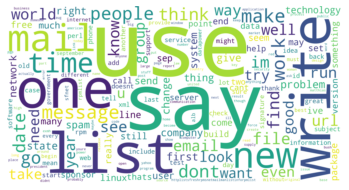

In [15]:
body_text = ' '.join(text for text in p_data[df.label==0].body)
normal_mail_wordcloud = WordCloud(collocations=False, background_color='white', width=2048, height=1080).generate(body_text)

normal_mail_wordcloud.to_file('normal_mail_wordcloud.png')

plt.imshow(normal_mail_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

<h4>Phishing Mails Word Cloud</h4>

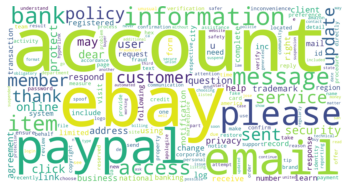

In [48]:
body_text = ' '.join(text for text in p_data[df.label == 1].body)
phishing_mail_wordcloud = WordCloud(collocations = False, background_color = 'white', width = 2048, height = 1080).generate(body_text)

phishing_mail_wordcloud.to_file('phishing_mail_wordcloud.png')

plt.imshow(phishing_mail_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [49]:
p_data['email'] = df['email'].apply(lambda x: x[0])
p_data['urls'] = df.urls.copy()
p_data['no_of_urls'] = p_data.urls.apply(lambda x: len(x))
p_data['label'] = df.label.copy()

<h4> Counting most frequent words in Normal and Phishing Mails </h4>

In [50]:
cnt = Counter()
for text in p_data[p_data.label == 1].body.values:
  for word in text.split():
    cnt[word] += 1

for text in p_data[p_data.label == 1].subject.values:
  for word in text.split():
    cnt[word] += 1
        
phishing_freq_words = cnt.most_common(10)
phishing_freq_words = list(list(zip(*phishing_freq_words))[0])
print(phishing_freq_words)

['account', 'ebay', 'paypal', 'please', 'email', 'bank', 'information', 'access', 'item', 'message']


In [51]:
cnt = Counter()
for text in p_data[p_data.label == 0].body.values:
  for word in text.split():
    cnt[word] += 1

for text in p_data[p_data.label == 0].subject.values:
  for word in text.split():
    cnt[word] += 1
        
normal_freq_words = cnt.most_common(10)
normal_freq_words = list(list(zip(*normal_freq_words))[0])
print(normal_freq_words)

['one', 'list', 'use', 'would', 'get', 'like', '2002', 'new', 'wrote', 'people']


# Looking for some Features

<h4> Is the Phishing site is using host ip directly? </h4>
<li>Phishing mails generally contain links having no domain name</li>

In [54]:
def isHostIp(url):
  return bool(re.match(r'^((25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)$', url))

In [55]:
host_ips = list()

for idx, urls in p_data.urls.iteritems():
  c = 0
  for url in urls:
    if isHostIp(url):
      c+=1
    
  host_ips.append(c)

p_data['ip'] = host_ips

<h4> Finding URL Lenght </h4>
<li>Typically long url leads to fishy website</li>

In [56]:
url_lengths = list()

for idx, urls in p_data.urls.iteritems():
  max_len = 0
  for url in urls:
    max_len = max(len(url), max_len)

  url_lengths.append(max_len)

p_data['max_url_len'] = url_lengths

<h4> Finding redirection pattern </h4>
<li>Typically url with "//" shows redirection</li>

In [57]:
redirection = list()
for idx, urls in p_data.urls.iteritems():
  c = 0
  for url in urls:
    try:
      if "//" in url.split('http://')[1]:
        c += 1
    except:
      pass
    
  redirection.append(c)

p_data['redirection'] = redirection

<h4> Finding image url in links </h4>
<li>Generally Phishing mails contains more image urls</li>

In [58]:
def image_in_url(url):
  url = url.split('?')[0]
  parts = url.split('.')
  extension = parts[-1]
  imageTypes = ['jpg','jpeg','tiff','png','gif','bmp']
  if extension in imageTypes:
    return True
  else:
    return False

In [59]:
image_url = list()
for idx, urls in p_data.urls.iteritems():
  c = 0
  for url in urls:
    if image_in_url(url):
      c += 1
  image_url.append(c)

p_data['image_url'] = image_url

<h4> Looking for a good url </h4>
<li>Urls without "http://" or "https://" maybe phishing urls</li>
<li>I analyzed the data and found http links mostly</li>

In [60]:
def valid_url(url):
  return bool(re.match(r'http://|https://', url))

In [61]:
invalid_urls = list()
for idx, urls in p_data.urls.iteritems():
  c = 0
  for url in urls:
    if not valid_url(url):
      c += 1
  
  invalid_urls.append(c)

p_data['invalid_urls'] = invalid_urls

<h4> Counting the words in the mail </h4>

In [62]:
def count_words(text):
  return len(re.findall(r'\w+', text))

In [63]:
p_data['body_wordcount'] = p_data['body'].apply(count_words)
p_data['subject_wordcount'] = p_data['subject'].apply(count_words)

<h4> Extracting domain name and lookin gfor "-" in it. </h4>
<li>Urls with "-" can be suspicious</li>

In [64]:
def get_domain_name(url):
  if not valid_url(url):
    return ''
  if image_in_url(url):
    return ''
  else:
    x = url.split("://")[1]
    return x.split('/')[0]

In [65]:
p_url = list()
for idx, urls in p_data.urls.iteritems():
  c = 0
  for url in urls:
    domain = get_domain_name(url)
    if "-" in domain:
      c += 1

  p_url.append(c)

p_data['p_url'] = p_url

<h4> Looking for the words mostly used in pishing links </h4>

In [66]:
def scam_url(url):
  return bool(re.match(r'[^\b]\.([a-zA-Z]{2}|aero|asia|biz|cat|com|coop|edu|gov|info|int|jobs|mil|mobi|museum|name|net|org|pro|tel|travel)[\b/]', url))

In [67]:
scam_urls = list()
for idx, urls in p_data.urls.iteritems():
  c = 0
  for url in urls:
    if scam_url(url):
      c += 1

  scam_urls.append(c)

p_data['scam_url'] = scam_urls

## Looking for correlation from the extracted Features

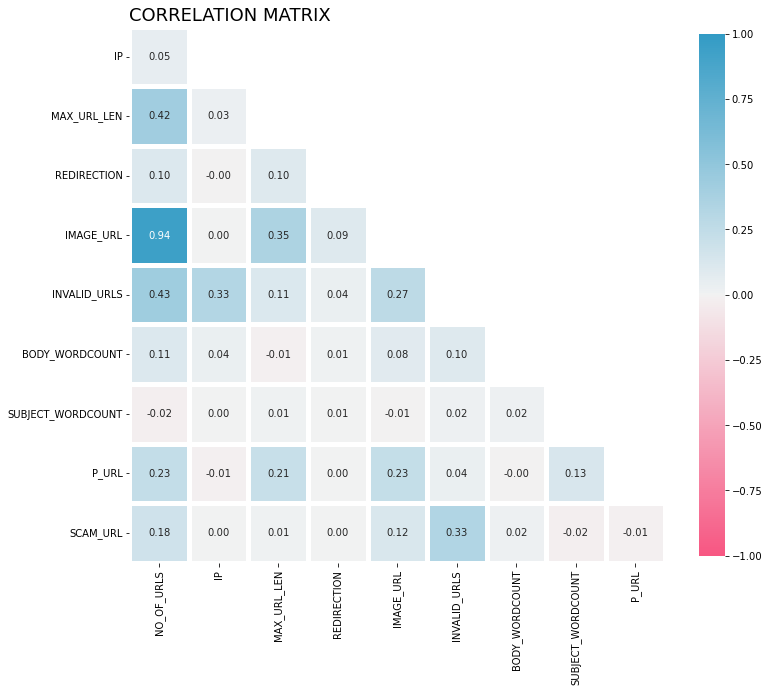

In [75]:
# Reference taken from https://12ft.io/proxy?q=https%3A%2F%2Ftowardsdatascience.com%2Fheatmap-basics-with-pythons-seaborn-fb92ea280a6c

features = p_data[['no_of_urls', 'ip', 'max_url_len', 'redirection', 'image_url', 'invalid_urls', 'body_wordcount', 'subject_wordcount', 'p_url', 'scam_url']]

df_corr = features.corr()

fig, ax = plt.subplots(figsize=(12, 12))

mask = np.triu(np.ones_like(df_corr, dtype=bool))
mask = mask[1:, :-1]
corr = df_corr.iloc[1:,:-1].copy()

cmap = sb.diverging_palette(0, 230, 90, 60, as_cmap=True)

sb.heatmap(
  corr, mask=mask, annot=True, fmt=".2f", 
  linewidths=5, cmap=cmap, vmin=-1, vmax=1, 
  cbar_kws={"shrink": .8}, square=True
  )

yticks = [i.upper() for i in corr.index]
xticks = [i.upper() for i in corr.columns]

plt.yticks(plt.yticks()[0], labels=yticks, rotation=0)
plt.xticks(plt.xticks()[0], labels=xticks)

plt.title("CORRELATION MATRIX", loc='left', fontsize=18)
plt.show()

In [79]:
p_data.to_csv("cleaned_data.csv", index_label=False, encoding='utf-8')